In [1]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

# Titanic Competition

0. Loading in the data
1. EDA
2. Preprocessing and Feature Engineering
3. Modeling
4. Final Model Diagnostics and Predictions

## 0: Loading in the data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1. EDA

Decided to investigate how each column related with respect to the target

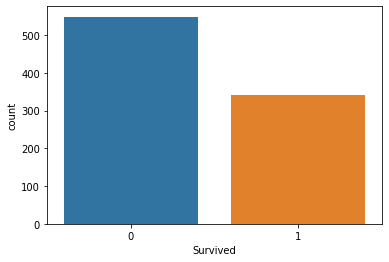

In [3]:
# Some class imbalance, but not extreme
sns.countplot(x='Survived', data=train);

### 1.2 Categorical Features

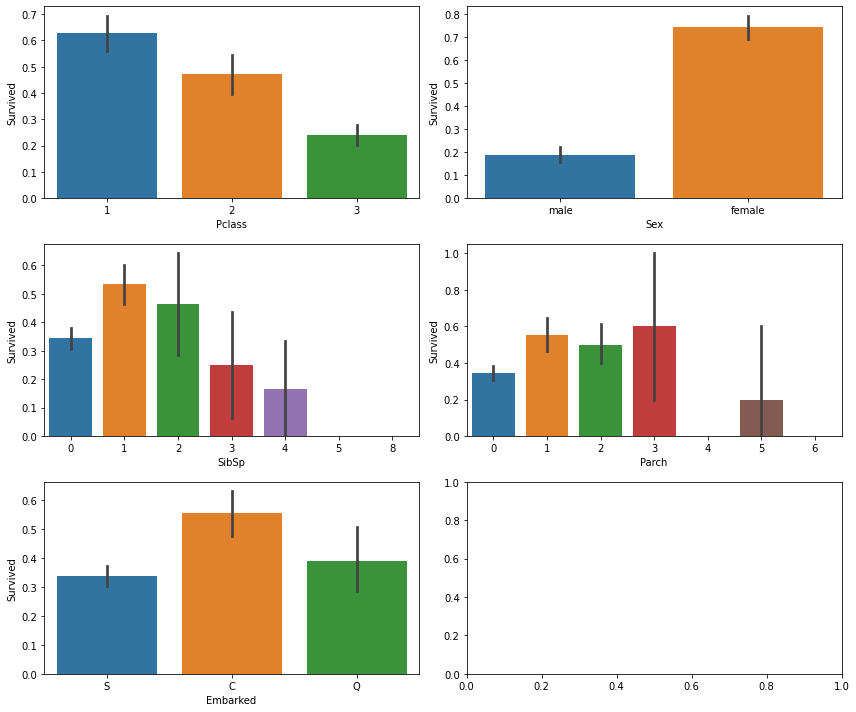

In [4]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=False)
sns.barplot(x='Pclass', y='Survived', data=train, ax=ax[0, 0]);
sns.barplot(x='Sex', y='Survived', data=train, ax=ax[0, 1]);
sns.barplot(x='SibSp', y='Survived', data=train, ax=ax[1, 0]);
sns.barplot(x='Parch', y='Survived', data=train, ax=ax[1, 1]);
sns.barplot(x='Embarked', y='Survived', data=train, ax=ax[2, 0]);
fig.tight_layout()

1. Higher classes more likely to survive
2. Females much more likely to survive
3. Passengers with 1 or 2 siblings or spouses more likely to survive
4. Passengers with 1 2 or 3 parents or children more likely to survive
5. Passengers from Cherbourg more likely to survive

In [5]:
# Difficult to find pattern in ticket, but there are some repeats
## Maybe due to families with young children?
print(len(train['Ticket'].unique()))
train['Ticket'].unique()[:10]

681


array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736'], dtype=object)

In [6]:
# First letter may give an indication of survival?
print(len(train['Cabin'].unique()))
train['Cabin'].unique()[:10]

148


array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78'], dtype=object)

### 1.2 Continuous Features

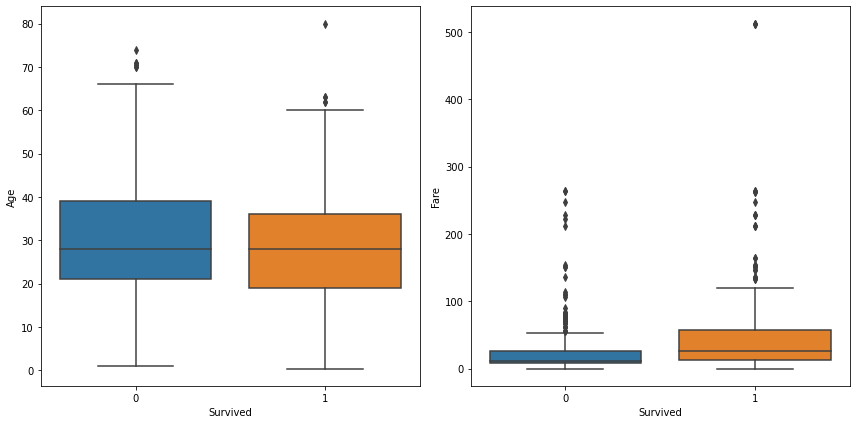

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=False)
sns.boxplot(x='Survived', y='Age', data=train, ax=ax[0]);
sns.boxplot(x='Survived', y='Fare', data=train, ax=ax[1]);
plt.tight_layout();

1. Not much differentiation, but appears that non-survivors were slightly older
2. A good amount of outliers, but survivors had a higher fare

### 1.3 Name

In [8]:
train['Name'].unique()[:20]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima'], dtype=object)

## 2. Preproccessing and Feature Engineering

### 2.1 Replacing Missing Data

In [70]:
def replace_age(df):
    """
    Replace missing ages with the Median amongst all passengers with the same title
    - if subdf is empty, then replace with overall Median
    """
    replaced = df.copy()
    
    replaced['Title'] = replaced['Name'].str.split(", ").str[1].str.split(" ").str[0]
    for i in np.arange(len(replaced)):
        age = replaced.loc[i, 'Age']
        if pd.isnull(age):
            title = replaced.loc[i, 'Title']
            sub_df = replaced[replaced['Title'] == title]
            if sum(~sub_df['Age'].isna()) == 0:
                replaced.loc[i, 'Age'] = np.nanmedian(replaced['Age'])
            else:
                replaced.loc[i, 'Age'] = np.nanmedian(sub_df['Age'])
    replaced = replaced.drop(['Title'], axis=1)
    
    return replaced

In [71]:
def replace_face(df):
    """
    Replace missing face with the Median amongst all passengers from the same class
    """
    replaced = df.copy()

    for i in np.arange(len(replaced)):
        fare = replaced.loc[i, 'Fare']
        if pd.isnull(fare):
            pclass = replaced.loc[i, 'Pclass']
            sub_df = replaced[replaced['Pclass'] == pclass]
            replaced.loc[i, 'Fare'] = np.nanmedian(sub_df['Fare'])

    return replaced

### 2.2 New Features

Additional features to be implemented:
- Bin Age for kids
- child, adult, senior (>= 65)

In [72]:
# Noticed several titles in name column
def ohe_names(df):
    """
    Take in dataframe with Name column, extract titles as features
    Return cleaned dataframe
    
    - ignored Dr., Rev., Master. to prevent overfitting
    """
    cleaned = df.copy()
    titles = ['Mr\.', 'Mrs\.', 'Miss\.']
    for title in titles:
        cleaned[title] = cleaned['Name'].str.contains(title)
        cleaned[title] = cleaned[title].fillna(0)
        cleaned[title] = cleaned[title].astype(int)

    # ".*" indicates nickname
    cleaned['nickname'] = cleaned['Name'].str.contains('"')
    cleaned['nickname'] = cleaned['nickname'].fillna(0)
    cleaned['nickname'] = cleaned['nickname'].astype(int)
    
    cleaned = cleaned.drop(['Name'], axis=1)

    return cleaned

In [73]:
# Cabin letters may be some indication, so we extract first letter
def add_cabin(df):
    """
    Add feature called "knownCabin"
    - binary that equals 1 if cabin is known
    
    Not going to use A-F because so many are missing - prevent overfitting
    Return cleaned dataframe
    """
    cleaned = df.copy()    
    cleaned['knownCabin'] = cleaned['Cabin'].isna().astype(int)
    cleaned = cleaned.drop(['Cabin'], axis=1)
    
    return cleaned

In [74]:
def encode_ticket(df):
    """
    Tickets are either integers or have letters/numbers at the beginning
    Denote pure integer tickets as "normal" and denote others as "special"
    """
    cleaned = df.copy()
    cleaned['specialTicket'] = cleaned['Ticket'].str.contains(" ")
    cleaned['specialTicket'] = cleaned['specialTicket'].fillna(0)
    cleaned['specialTicket'] = cleaned['specialTicket'].astype(int)
    cleaned = cleaned.drop(['Ticket'], axis=1)
    
    return cleaned

In [75]:
def add_familysize_and_alone(df):
    """
    Researched that passengers who traveled alone were less likely to survive
    Create binary variable that denotes "Alone"
    Also combined Sibsp and Parch to create "family size" variable
        - drop Sibsp and Parch after
    """
    cleaned = df.copy()
    cleaned['familySize'] = cleaned['SibSp'] + cleaned['Parch']
    # Alone Column - no sibsp and no parch
    cleaned['Alone'] = [1 if x == 0 else 0 for x in cleaned['familySize']]
    
    cleaned = cleaned.drop(['SibSp', 'Parch'], axis=1)
    
    return cleaned

### 2.3 Interactions

In [76]:
# Create intermediate dataframe to look at interaction with Alone
train_with_alone = add_familysize_and_alone(train)

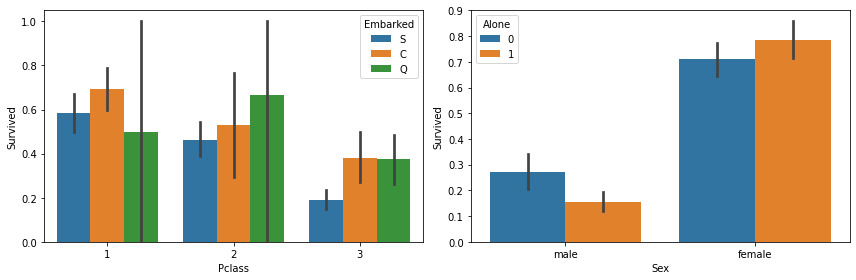

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False)
sns.barplot(x='Pclass', y='Survived', hue='Embarked', data=train_with_alone, ax=ax[0]);
sns.barplot(x='Sex', y='Survived', hue='Alone', data=train_with_alone, ax=ax[1]);
fig.tight_layout()

1. Survival proportion varies by class and embarkation
2. Males who were alone much less likely to survive compared to females who were alone.

In [78]:
def sex_alone_interaction(df):
    """
    Add interaction between sex and alone variables
    - Handles OHE of Sex
    """
    cleaned = df.copy()
    
    sex_dummies = pd.get_dummies(cleaned['Sex'], prefix='Sex', prefix_sep='_')
    cleaned = cleaned.join(sex_dummies)
    cleaned = cleaned.drop(['Sex'], axis=1)
    cleaned['male:Alone'] = cleaned['Sex_male'] * cleaned['Alone']
    
    return cleaned

In [79]:
def add_pclass_embarked(df):
    """
    Add interaction between Pclass and Embarked variables
    - Handles OHE of Pclass, Embarked
    """
    df['Pclass'] = df['Pclass'].astype(str)
    cleaned = df.copy()
    
    # OHE
    features = ['Pclass', 'Embarked']
    for feature in features:
        dummies = pd.get_dummies(cleaned[feature], prefix=feature, prefix_sep='_')
        cleaned = cleaned.join(dummies)
        cleaned = cleaned.drop([feature], axis=1)
    
    # Embarked:Pclass
    for pclass in df['Pclass'].unique():
         for embark in df['Embarked'].unique():
            embark_colName = 'Embarked_' + embark
            pclass_colName = 'Pclass_' + pclass
            new_colName = embark_colName + ':' + pclass_colName
            cleaned[new_colName] = cleaned[pclass_colName] * cleaned[embark_colName]    
    
    return cleaned

### 2.3 Preprocessing

In [80]:
def preProcess(df):
    """
    Preprocess Raw Dataframe into design matrix (w/ response column)
    """
    processed = df.copy()
    processed = processed.drop(['PassengerId'], axis=1)
    
    # Fill age, fare with Median
#     processed['Age'] = processed['Age'].fillna(np.nanmedian(processed['Age']))
    processed = replace_age(processed)
#     processed['Fare'] = processed['Fare'].fillna(np.nanmedian(processed['Fare']))
    processed = replace_face(processed)
    # Fill embarked with majority class (only two NA)
    processed['Embarked'] = processed['Embarked'].fillna('S')
    
    # New Features
    processed = ohe_names(processed)
    processed = add_cabin(processed)
    processed = encode_ticket(processed)
    processed = add_familysize_and_alone(processed)
    
    # Interactions - OHE of Sex, Pclass, Embark
    processed = sex_alone_interaction(processed)
    processed = add_pclass_embarked(processed)
    
    # Convert Parch to 6 if value 6 or more (outliers between train and test)
#     processed['Parch'] = [x if x < 6 else 6 for x in processed['Parch']]
    
#     # OHE other categorical Features
#     processed['SibSp'] = processed['SibSp'].astype(str)
#     processed['Parch'] = processed['Parch'].astype(str)
#     categorical_features = ['SibSp', 'Parch']
#     for feature in categorical_features:
#         dummies = pd.get_dummies(processed[feature], prefix=feature, prefix_sep='_')
#         processed = processed.join(dummies)
#         processed = processed.drop([feature], axis=1)
    
    # Standardize Continuous Features
    def norm(vec):
        return (vec - np.mean(vec)) / np.std(vec)
    
    processed['Age'] = norm(processed['Age'])
    processed['Fare'] = norm(processed['Fare'])
    
    return processed

In [81]:
trainClean = preProcess(train)
testClean = preProcess(test)
trainClean.head()

,Survived,Age,Fare,Mr\.,Mrs\.,Miss\.,nickname,knownCabin,specialTicket,familySize,...,Embarked_S,Embarked_S:Pclass_3,Embarked_C:Pclass_3,Embarked_Q:Pclass_3,Embarked_S:Pclass_1,Embarked_C:Pclass_1,Embarked_Q:Pclass_1,Embarked_S:Pclass_2,Embarked_C:Pclass_2,Embarked_Q:Pclass_2
0,0,-0.557420,-0.502445,1,0,0,0,1,1,1,...,1,1,0,0,0,0,0,0,0,0
1,1,0.649410,0.786845,0,1,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,1,-0.255712,-0.488854,0,0,1,0,1,1,0,...,1,1,0,0,0,0,0,0,0,0
3,1,0.423129,0.420730,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
4,0,0.423129,-0.486337,1,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0


In [82]:
print(f'Features: {trainClean.columns.values}')

Features: ['Survived' 'Age' 'Fare' 'Mr\\.' 'Mrs\\.' 'Miss\\.' 'nickname'
 'knownCabin' 'specialTicket' 'familySize' 'Alone' 'Sex_female' 'Sex_male'
 'male:Alone' 'Pclass_1' 'Pclass_2' 'Pclass_3' 'Embarked_C' 'Embarked_Q'
 'Embarked_S' 'Embarked_S:Pclass_3' 'Embarked_C:Pclass_3'
 'Embarked_Q:Pclass_3' 'Embarked_S:Pclass_1' 'Embarked_C:Pclass_1'
 'Embarked_Q:Pclass_1' 'Embarked_S:Pclass_2' 'Embarked_C:Pclass_2'
 'Embarked_Q:Pclass_2']


## 3. Modeling

Because the training data contains only 891 rows, I decided to avoid more complex models, such as neural networks. Without extensive tuning, they would be very prone to overfitting on a small dataset. Simpler models, such as Logistic Regression, Random Forest, and K Nearest Neighbor models can be more easily optimized, and are less prone to overfitting.

In [25]:
Y_train = trainClean['Survived']
X_train = trainClean.drop(['Survived'], axis=1)

In [26]:
def cross_val_acc(model, X_train, Y_train, k):
    '''
    Compute k-fold Cross Validation accuracy

    Inputs:
        model: an sklearn model with fit and predict functions 
        X_train: Design Matrix
        Y_train: Response Vector
    Outputs:
        the average validation MSE for the k splits.
    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    validation_accuracies = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit model
        model.fit(split_X_train, split_Y_train)
        
        # Compute Accuracy on the validation split
        acc = model.score(split_X_valid, split_Y_valid)
        validation_accuracies.append(acc)
        
    return np.mean(validation_accuracies)

In [27]:
# Initialize
K = 5
RANDOM_STATE = 42

### 3.1 Logistic Regression

Investigate Baseline Model without Tuning

In [28]:
logreg = LogisticRegression(random_state=RANDOM_STATE)

cv_acc = cross_val_acc(logreg, X_train, Y_train, K)
print(f'Logistic Regression {K} Fold CV Accuracy = {cv_acc}')

logreg.fit(X_train, Y_train)
print(f'Logistic Regression Training Accuracy = {logreg.score(X_train, Y_train)}')

Logistic Regression 5 Fold CV Accuracy = 0.8215554579122465
Logistic Regression Training Accuracy = 0.8372615039281706


### 3.2 Random Forest

In [29]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

cv_acc = cross_val_acc(rf, X_train, Y_train, K)
print(f'Random Forest {K} Fold CV Accuracy = {cv_acc}')

rf.fit(X_train, Y_train)
print(f'Random Forest Training Accuracy = {rf.score(X_train, Y_train)}')

Random Forest 5 Fold CV Accuracy = 0.8091707990709937
Random Forest Training Accuracy = 0.9876543209876543


### 3.3 K Nearest Neighbors

In [87]:
knn = KNeighborsClassifier(n_neighbors=5)
cv_acc = cross_val_acc(knn, X_train, Y_train, K)
print(f'K-Nearest Neighbors {K} Fold CV Accuracy = {cv_acc}')

knn.fit(X_train, Y_train)
print(f'K-Nearest Neighbors  Training Accuracy = {knn.score(X_train, Y_train)}')

K-Nearest Neighbors 5 Fold CV Accuracy = 0.8002196974452327
K-Nearest Neighbors  Training Accuracy = 0.8608305274971941


### 3.4 Hyperparameter Tuning

There is overfitting in all cases with the baseline models, so we will perform hyperparameter tuning

In [88]:
def gridSearch(pipe, param_grid, X_train, Y_train, K):
    """
    Returns best hyperparameters for a particular model based on training data
    """
    # Create grid search object
    clf = GridSearchCV(pipe, param_grid=param_grid, cv=K, verbose=True, n_jobs=-1)
    # Fit on data
    best_model = clf.fit(X_train, Y_train)
    
    return best_model

In [89]:
# Find Best Logistic Regression
pipe = Pipeline([('classifier' , LogisticRegression(random_state=RANDOM_STATE, 
                                                    max_iter=500))])

# Create param grid.
param_grid = [
    {'classifier' : [LogisticRegression(random_state=RANDOM_STATE, max_iter=500)],
     'classifier__penalty' : ['l1', 'l2', 'elasticnet'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['saga']}
]

# Fit on data
best_logreg = gridSearch(pipe, param_grid, X_train, Y_train, K)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.9s finished


In [90]:
best_logreg.best_estimator_.get_params()['classifier']

LogisticRegression(C=0.23357214690901212, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Best Logistic Regression Accuracy =  0.8271483271608814


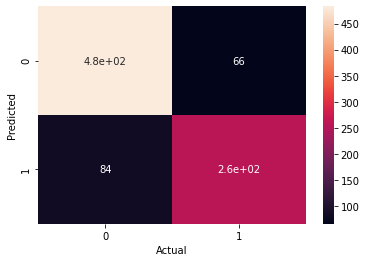

In [91]:
# Confusion Matrix for Training Data
print('Best Logistic Regression Accuracy = ', best_logreg.best_score_)
## Have more False Positives that False Negatives
y_pred = best_logreg.predict(X_train)
sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
plt.ylabel('Predicted');
plt.xlabel('Actual');

In [92]:
# Find Best Random Forest
pipe = Pipeline([('classifier' , RandomForestClassifier(random_state=RANDOM_STATE))])

# Create param grid.
param_grid = [
    {'classifier' : [RandomForestClassifier(random_state=RANDOM_STATE)],
    'classifier__n_estimators' : np.arange(30, 101, 5),
    'classifier__max_features' : ['sqrt', 'log2', None],
    'classifier__max_depth' : np.arange(4, 11),
    'classifier__min_samples_leaf' : np.arange(1, 4),
    'classifier__oob_score' : [False, True]}
]

# Fit on data
best_rf = gridSearch(pipe, param_grid, X_train, Y_train, K)

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3036 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3686 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4436 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 5286 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 6236 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 7286 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 8436 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 9450 out of 9450 | elapsed: 10.0min finished


In [99]:
best_rf.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=65,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Best Random Forest Accuracy =  0.8406063649488418


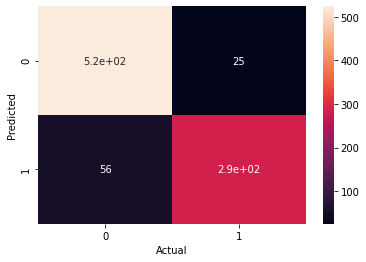

In [100]:
# Confusion Matrix for Training Data
print('Best Random Forest Accuracy = ', best_rf.best_score_)
## Have more False Positives that False Negatives
y_pred = best_rf.predict(X_train)
sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
plt.ylabel('Predicted');
plt.xlabel('Actual');

In [101]:
# Find Best KNN
pipe = Pipeline([('classifier' , KNeighborsClassifier())])

# Create param grid.
param_grid = [
    {'classifier' : [KNeighborsClassifier()],
    'classifier__n_neighbors' : np.arange(3, 30, 2),
    'classifier__weights' : ['uniform', 'distance']}
]

# Fit on data
best_knn = gridSearch(pipe, param_grid, X_train, Y_train, K)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.7s finished


In [102]:
best_knn.best_estimator_.get_params()['classifier']

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

Best K Nearest Neighbors Accuracy =  0.8148389931579938


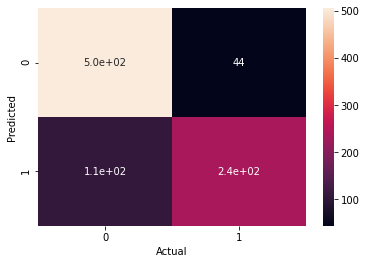

In [103]:
# Confusion Matrix for Training Data
print('Best K Nearest Neighbors Accuracy = ', best_knn.best_score_)
## Have more False Positives that False Negatives
y_pred = best_knn.predict(X_train)
sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
plt.ylabel('Predicted');
plt.xlabel('Actual');

## 4. Final Model Diagnostics and Predictions

All 3 models have a few more false positives, but splits are slightly different. Will Use voting classifier to utilize all 3 models.

In [105]:
lr = best_logreg.best_estimator_.get_params()['classifier']
rf = best_rf.best_estimator_.get_params()['classifier']
knn = best_knn.best_estimator_.get_params()['classifier']

eclf = VotingClassifier(estimators=[
    ('lr', lr), ('rf', rf), ('knn', knn)], voting='hard')

In [106]:
cv_acc = cross_val_acc(eclf, X_train, Y_train, K)
print(f'Voting Model {K} Fold CV Accuracy = {cv_acc}')

eclf = eclf.fit(X_train, Y_train)
print(f'Voting Model Training Accuracy = {eclf.score(X_train, Y_train)}')

Voting Model 5 Fold CV Accuracy = 0.8305191136777352
Voting Model Training Accuracy = 0.8619528619528619


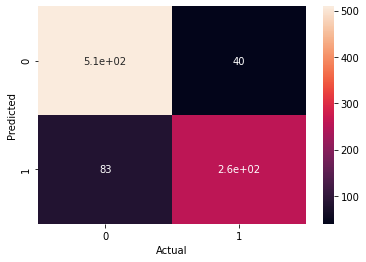

In [107]:
# Confusion Matrix for Voting model on Training Data
## Have more False Positives that False Negatives
y_pred = eclf.predict(X_train)
sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
plt.ylabel('Predicted');
plt.xlabel('Actual');

In [108]:
# Make Final Predictions
test_preds = eclf.predict(testClean)
submission = pd.DataFrame({'PassengerId': test['PassengerId'],
                          'Survived': test_preds})
submission.to_csv('data/submission.csv', index=False)

**Final Results**

77.751% Accuracy on Kaggle Public Leaderboard